# Detectron2: Instance Segmentation
<img src="https://dl.fbaipublicfiles.com/detectron2/Detectron2-Logo-Horz.png" width="500">

<table align="left"><td>
  <a target="_blank"  href="https://colab.research.google.com/github/TannerGilbert/Detectron2-Train-a-Instance-Segmentation-Model/blob/master/Microcontroller_Instance_Segmentation.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab
  </a>
</td><td>
  <a target="_blank"  href="https://github.com/TannerGilbert/Detectron2-Train-a-Instance-Segmentation-Model/blob/master/Microcontroller_Instance_Segmentation.ipynb">
    <img width=32px src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
</td></table>

In [ ]:
!pip install pyyaml==5.1

import torch
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
# Install detectron2 that matches the above pytorch version
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
!pip install 'git+https://github.com/facebookresearch/detectron2.git'
# If there is not yet a detectron2 release that matches the given torch + CUDA version, you need to install a different pytorch.

# exit(0)  # After installation, you may need to "restart runtime" in Colab. This line can also restart runtime

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Get data

In [ ]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import cv2
import matplotlib.pyplot as plt

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

In [ ]:
!cp /content/drive/MyDrive/Detectron2/SchapovDataset1/*.* ../content

In [ ]:
!unzip ../content/Datasetv1.zip
!ls

In [ ]:
!ls

Datasetv1.zip  labelme2coco.py	test	   train
drive	       sample_data	test.json  train.json


In [ ]:
from detectron2.utils.logger import setup_logger
setup_logger()
from detectron2.data.datasets import register_coco_instances
from detectron2.engine import DefaultTrainer

import os
import pickle

# COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml
# COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml

config_file_path = 'COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml'
checkpoint_url = 'COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml'

output_dir = './drive/MyDrive/Detectron2/output/detection_small'
num_classes = 2

In [ ]:
device = 'cuda'
train_dataset_name = 'LP_train'
train_images_path = 'train'
train_json_annont_path = 'train.json'

test_dataset_name = 'LP_test'
test_images_path = 'test'
test_json_annont_path = 'test.json'

In [ ]:
register_coco_instances(name = train_dataset_name, metadata={}, json_file=train_json_annont_path, image_root=train_images_path)
register_coco_instances(name = test_dataset_name, metadata={}, json_file=test_json_annont_path, image_root=test_images_path)

In [ ]:
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.utils.visualizer import Visualizer
from detectron2.config import get_cfg
from detectron2 import model_zoo

from detectron2.utils.visualizer import ColorMode

import random
import cv2 as cv
import matplotlib.pyplot as plt

def plot_samples(dataset_name, n=1):
  dataset_custom = DatasetCatalog.get(dataset_name)
  dataset_custom_metadata = MetadataCatalog.get(dataset_name)
  for s in random.sample(dataset_custom, n):
    img = cv.imread(s['file_name'])
    v = Visualizer(img[:,:,::-1], metadata=dataset_custom_metadata, scale=0.5)
    v = v.draw_dataset_dict(s)
    plt.figure(figsize=(15,20))
    plt.imshow(v.get_image())
    plt.show()


WARNING [05/04 08:36:00 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[05/04 08:36:00 d2.data.datasets.coco]: Loaded 995 images in COCO format from train.json


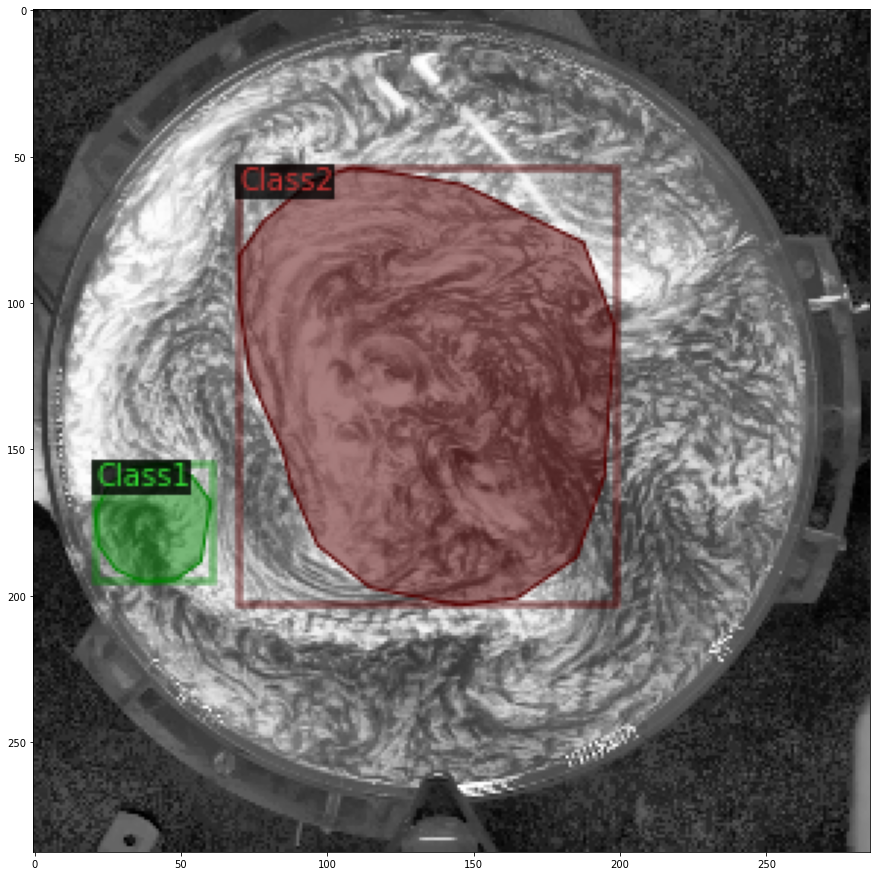

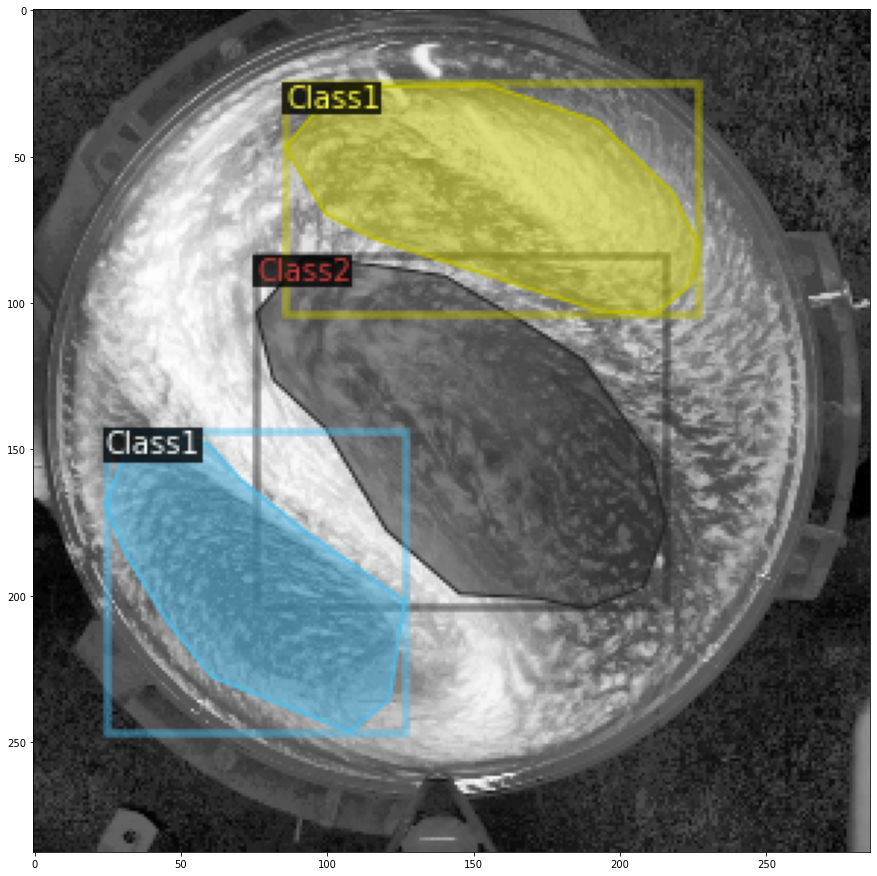

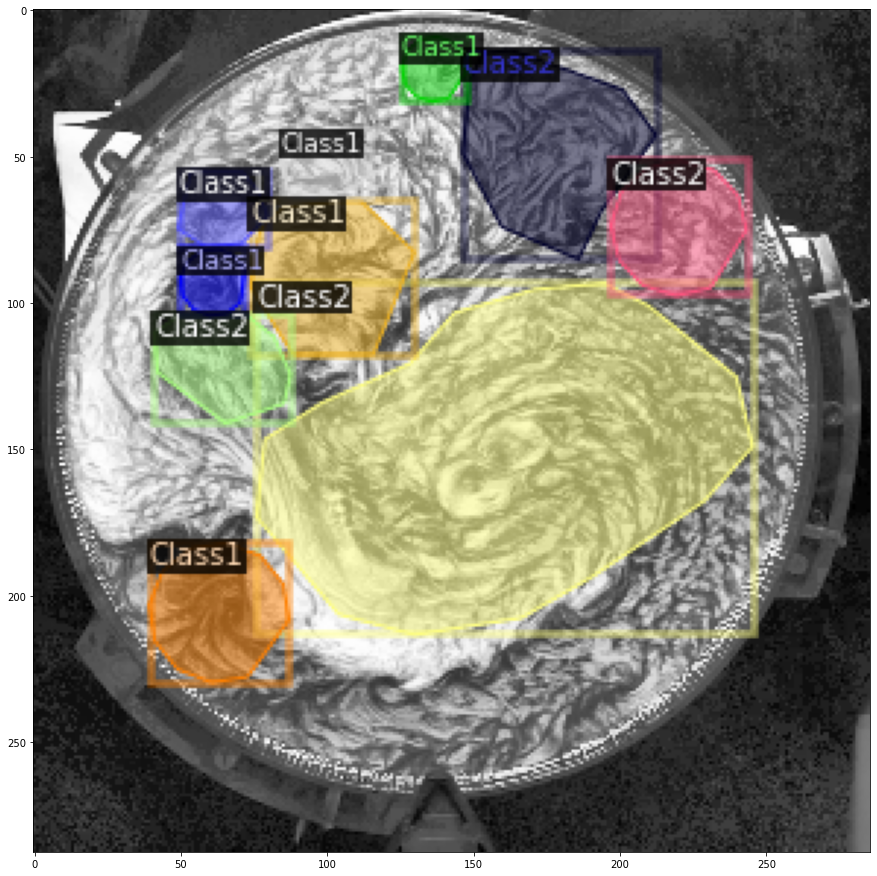

In [ ]:
plot_samples(dataset_name=train_dataset_name, n =3)


In [ ]:

def get_train_cfg(config_file_path, checkpoint_url, train_dataset_name, test_dataset_name, num_classes, device, output_dir):
  cfg = get_cfg()

  cfg.merge_from_file(model_zoo.get_config_file(config_file_path))
  cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(checkpoint_url)
  cfg.DATASETS.TRAIN = (train_dataset_name,)
  cfg.DATASETS.TEST = (test_dataset_name,)

  cfg.DATALOADER.NUM_WORKERS = 2
  cfg.SOLVER.IMS_PER_BATCH = 4
  cfg.SOLVER.BASE_LR = 0.000025
  cfg.SOLVER.MAX_ITER = 1500
  cfg.SOLVER.STEPS = []

  cfg.MODEL.ROI_HEADS.NUM_CLASSES = num_classes
  cfg.MODEL.DEVICE = device
  cfg.OUTPUT_DIR = output_dir

  return cfg
cfg_save_path = './drive/MyDrive/Detectron2/Detect_small_cfg.pickle'

In [ ]:
# with torch.no_grad():
#     torch.cuda.empty_cache()

In [ ]:
# !pip install numba

In [ ]:
# from numba import cuda
# # all of your code and execution
# cuda.select_device(0)
# cuda.close()

In [ ]:
from detectron2 import checkpoint

def main():
  cfg = get_train_cfg(config_file_path, checkpoint_url, train_dataset_name, test_dataset_name, num_classes, device, output_dir)
  with open(cfg_save_path, 'wb') as f:
    pickle.dump(cfg, f, protocol=pickle.HIGHEST_PROTOCOL)
  os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

  trainer = DefaultTrainer(cfg)
  trainer.resume_or_load(resume=True)
  trainer.train()

main()


[05/04 08:38:04 d2.utils.events]:  eta: 0:22:43  iter: 1019  total_loss: 0.5746  loss_cls: 0.2532  loss_box_reg: 0.2692  loss_rpn_cls: 0.03988  loss_rpn_loc: 0.02171  time: 2.8306  data_time: 0.0422  lr: 2.5e-05  max_mem: 6704M
[05/04 08:39:02 d2.utils.events]:  eta: 0:21:53  iter: 1039  total_loss: 0.5719  loss_cls: 0.2634  loss_box_reg: 0.2391  loss_rpn_cls: 0.03261  loss_rpn_loc: 0.02839  time: 2.8557  data_time: 0.0363  lr: 2.5e-05  max_mem: 6704M
[05/04 08:40:01 d2.utils.events]:  eta: 0:21:58  iter: 1059  total_loss: 0.7037  loss_cls: 0.3092  loss_box_reg: 0.3335  loss_rpn_cls: 0.04559  loss_rpn_loc: 0.0363  time: 2.8759  data_time: 0.0337  lr: 2.5e-05  max_mem: 6704M
[05/04 08:40:59 d2.utils.events]:  eta: 0:20:30  iter: 1079  total_loss: 0.6035  loss_cls: 0.2744  loss_box_reg: 0.2487  loss_rpn_cls: 0.04454  loss_rpn_loc: 0.02701  time: 2.8831  data_time: 0.0285  lr: 2.5e-05  max_mem: 6704M
[05/04 08:41:57 d2.utils.events]:  eta: 0:20:00  iter: 1099  total_loss: 0.6009  loss_cls

[05/03 19:39:03 d2.checkpoint.c2_model_loading]: Following weights matched with model:
| Names in Model                                  | Names in Checkpoint                                                                                  | Shapes                                          |
|:------------------------------------------------|:-----------------------------------------------------------------------------------------------------|:------------------------------------------------|
| backbone.bottom_up.res2.0.conv1.*               | backbone.bottom_up.res2.0.conv1.{norm.bias,norm.running_mean,norm.running_var,norm.weight,weight}    | (64,) (64,) (64,) (64,) (64,64,1,1)             |
| backbone.bottom_up.res2.0.conv2.*               | backbone.bottom_up.res2.0.conv2.{norm.bias,norm.running_mean,norm.running_var,norm.weight,weight}    | (64,) (64,) (64,) (64,) (64,64,3,3)             |
| backbone.bottom_up.res2.0.conv3.*               | backbone.bottom_up.res2.0.conv3.{norm.bia

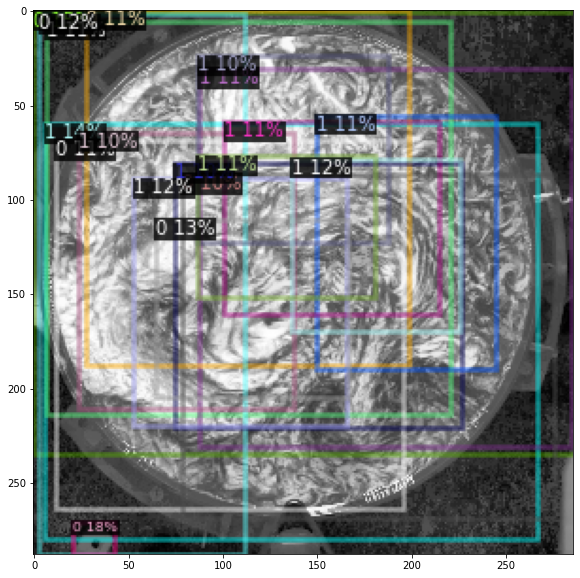

In [ ]:
from detectron2.engine import DefaultPredictor

def on_image(image_path, predictor):
  im = cv.imread(image_path)
  outputs = predictor(im)
  v = Visualizer(im[:,:,::-1], metadata={}, scale=0.5, instance_mode=ColorMode.SEGMENTATION)
  v = v.draw_instance_predictions(outputs['instances'].to('cpu'))

  plt.figure(figsize=(14, 10))
  plt.imshow(v.get_image())
  plt.show()

def on_video(videoPath, predicor):
  cap = cv.VideoCapture(videoPath)
  if (cap.isOpened() == False):
    print('Error opening file...')
    return
  (success, image) = cap.read()
  while success:
    predictions = predictor(image)
    v = Visualizer(image[:,:,::-1], metadata={}, instance_mode=ColorMode.SEGMENTATION)
    output = v.draw_instance_predictions(predictions['instances'].to('cpu'))

    plt.figure(figsize=(14, 10))
    plt.imshow(output.get_image()[:,:,::-1])
    plt.show()



with open(cfg_save_path, 'rb') as f:
  cfg = pickle.load(f)
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, 'model_final.pth')
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.1

predictor = DefaultPredictor(cfg)

image_path = '/content/drive/MyDrive/Detectron2/video21-00001.png'
video_path = '/content/drive/MyDrive/Detectron2/00026.MTS'

on_image(image_path, predictor)
# on_video(video_path, predictor)